In [2]:
import io
from google.colab import files
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import isnan
from sklearn.metrics import r2_score
import seaborn as sn
import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from google.colab import drive

%matplotlib inline

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inspect the data

In [4]:
with open('/content/drive/MyDrive/MachineLearningProject/Dataset/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv', 'r') as f:
  hist = pd.read_csv(f)

In [5]:
def replace_NaN(df):
  array = df.to_numpy()
  for i in range(len(array)-1):
     column_index = 0
     for value in array[i+1]:
       if isnan(value):
         array[i+1, column_index] = array[i, column_index] 
       column_index += 1
  return pd.DataFrame(data = array, columns = df.columns)

In [6]:
hist.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
hist.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831
4727776,1609372800,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


In [8]:
hist_copy = hist.copy()
hist.shape

(4727777, 8)

In [9]:
hist = replace_NaN(hist)
hist.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [10]:
hist["Close"].max()

28997.38

In [11]:
hist["Open"].max()

28997.38

In [12]:
hist = hist.set_index(['Timestamp'])
hist.index = pd.to_datetime(hist.index, unit='s')

In [13]:
hist.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [14]:
hist_1h = hist.resample('1h')
hist_1h.asfreq()[0:5]   # Select first 5 rows

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 09:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 10:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 11:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [15]:
hist_1h.asfreq().tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 20:00:00,28807.89,28830.00,28768.13,28827.23,5.653226,1.628806e+05,28811.974988
2020-12-30 21:00:00,28789.77,28808.04,28673.31,28783.67,89.293552,2.566554e+06,28742.886742
2020-12-30 22:00:00,28896.96,28925.51,28896.96,28907.59,1.452840,4.200696e+04,28913.679200
2020-12-30 23:00:00,28731.27,28756.10,28714.03,28728.12,5.567706,1.599935e+05,28735.980712
2020-12-31 00:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,1.664497e+05,28909.166061


In [16]:
hist_1h = hist_1h.asfreq()
hist_1h.shape

(78906, 7)

In [17]:
hist_1h.isnull().sum()

Open                 109
High                 109
Low                  109
Close                109
Volume_(BTC)         109
Volume_(Currency)    109
Weighted_Price       109
dtype: int64

In [18]:
hist_1h =  hist_1h.dropna(axis = 0, how = 'any')

In [19]:
hist_1h.isnull().sum() #Should be zero

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

# Test-Train split

In [20]:
def train_test_split(array, test_size=0.2):
    split_row = len(array) - int(test_size * len(array))
    train_data = array[:split_row]
    test_data = array[split_row:]
    return train_data, test_data
    
train, test = train_test_split(hist_1h, test_size=0.2)

In [21]:
target_col = 'Close'
target_index = 3
hist_1h.iloc[20000:20005, target_index]

Timestamp
2014-04-12 16:00:00    423.53
2014-04-12 17:00:00    426.00
2014-04-12 18:00:00    425.00
2014-04-12 19:00:00    420.62
2014-04-12 20:00:00    425.20
Name: Close, dtype: float64

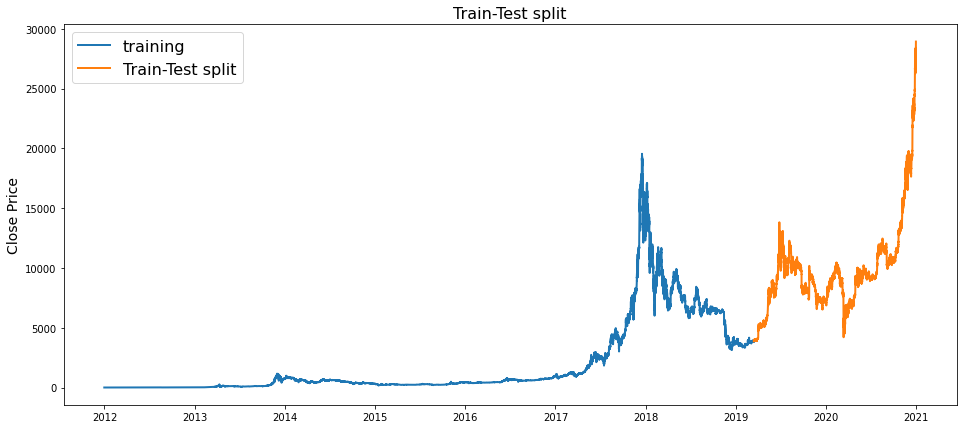

In [23]:
def line_plot(line1, line2, label1=None, label2=None, title='Train-Test split', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Close Price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot(train[target_col], test[target_col], 'training', 'Train-Test split')

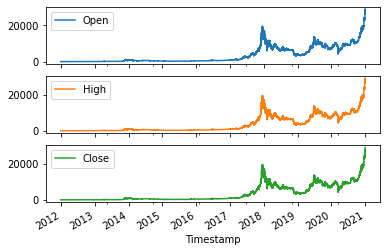

In [24]:
plot_cols = ['Open', 'High', 'Close']
plot_features = hist_1h[plot_cols]
_ = plot_features.plot(subplots=True)

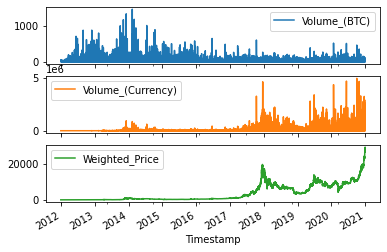

In [25]:
plot_cols = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
plot_features = hist_1h[plot_cols]
_ = plot_features.plot(subplots=True)



# Normalization

In [ ]:
#target = hist_1h[target_col].to_numpy()
#target = target.reshape(-1,1)
#scaler = StandardScaler()

#scaler2 = StandardScaler()
#scaler2.fit(target)

#hist_array = scaler.fit_transform(hist_1h)

In [26]:
target = hist_1h[target_col].to_numpy()
target = target.reshape(-1,1)
scaler = MinMaxScaler()

scaler2 = MinMaxScaler()
scaler2.fit(target)

hist_array = scaler.fit_transform(hist_1h)
hist_array.shape

(78797, 7)

In [27]:
hist_1h = pd.DataFrame(hist_array, columns=hist_1h.columns)

In [28]:
target.shape

(78797, 1)

In [29]:
hist_1h.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,0.000009,0.000009,0.000009,0.000009,0.000311,4.057409e-07,0.000009
1,0.000009,0.000009,0.000009,0.000009,0.000311,4.057409e-07,0.000009
2,0.000009,0.000009,0.000009,0.000009,0.000311,4.057409e-07,0.000009
3,0.000009,0.000009,0.000009,0.000009,0.000311,4.057409e-07,0.000009
4,0.000009,0.000009,0.000009,0.000009,0.000311,4.057409e-07,0.000009


In [30]:
hist_1h.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
78792,0.996917,0.996595,0.995541,0.996499,0.003865,0.033044,0.996482
78793,0.996290,0.995836,0.992259,0.994993,0.061050,0.520678,0.994092
78794,1.000000,0.999897,1.000000,0.999277,0.000993,0.008522,1.000000
78795,0.994265,0.994040,0.993669,0.993073,0.003807,0.032458,0.993853
78796,0.999870,1.000000,0.999870,1.000000,0.003937,0.033768,0.999844


In [31]:
hist_1h.shape

(78797, 7)



# Data windowing

In [32]:
def extract_window_data(array, window_len=24):
  X = []
  y  = []
  for i in range(window_len, len(array)):
      X.append(array[i-window_len:i])
      y.append(array[i, target_index])
  X, y = np.array(X), np.array(y)
  return X, y

In [33]:
def prepare_data(array, window_len=24, test_size=0.2):
    #We split the dataset into train and test
    train_data, test_data = train_test_split(array, test_size=test_size)
    #We extract all the possible windows
    X_train, y_train = extract_window_data(train_data, window_len)
    #We extract all the possible windows
    X_test, y_test = extract_window_data(test_data, window_len)
   
    return X_train, y_train, X_test, y_test

# LSTM model

In [34]:
def build_lstm_model(window_len, num_features, output_size, neurons=50, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units = neurons, input_shape =(window_len, num_features)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

**Parameters**

In [36]:
np.random.seed(42)
window_len = 48
test_size = 0.2
lstm_neurons = 100
epochs = 5
num_features = len(hist_1h.columns)
activ_func = 'linear'
batch_size = 32
loss = 'mae'
dropout = 0.2
output_size = 1
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [37]:
X_train, y_train, X_test, y_test = prepare_data(hist_array, window_len=window_len, test_size=test_size)

In [38]:
X_train.shape

(62990, 48, 7)

In [39]:
y_train.shape

(62990,)

In [40]:
model = build_lstm_model(window_len, num_features, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/5
1969/1969 [==============================] - 76s 37ms/step - loss: 0.0047 - mae: 0.0047
Epoch 2/5
1969/1969 [==============================] - 70s 35ms/step - loss: 0.0032 - mae: 0.0032
Epoch 3/5
1969/1969 [==============================] - 69s 35ms/step - loss: 0.0031 - mae: 0.0031
Epoch 4/5
1969/1969 [==============================] - 70s 35ms/step - loss: 0.0030 - mae: 0.0030
Epoch 5/5
1969/1969 [==============================] - 69s 35ms/step - loss: 0.0030 - mae: 0.0030


In [42]:
history.history

{'loss': [0.003640838200226426,
  0.0031545774545520544,
  0.0030655786395072937,
  0.003008501138538122,
  0.002934671938419342],
 'mae': [0.003640838200226426,
  0.0031545774545520544,
  0.0030655786395072937,
  0.003008501138538122,
  0.002934671938419342]}

In [ ]:
results = model.evaluate(X_test, y_test)

379/379 [==============================] - 4s 8ms/step - loss: 0.0022 - mae: 0.0022


In [43]:
preds = model.predict(X_test)

In [44]:
preds.shape

(15711, 1)

In [45]:
y_test = y_test.reshape(-1,1)

In [46]:
y_test.shape

(15711, 1)

In [47]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

In [49]:
def plot(real_values, predictions,  plot_col='Close', max_subplots=5, print_step  = 2500):
  plt.figure(figsize=(12, 8))
  x = []
  for i in range(30):
    x.append(i+1)
  for n in range(max_subplots):
    index = print_step * n
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.scatter(x, real_values[index:index+30], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(x, predictions[index:index+30], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

  plt.xlabel('Time [30h]')


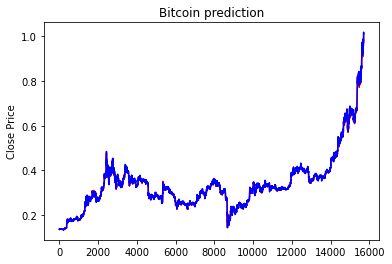

In [50]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

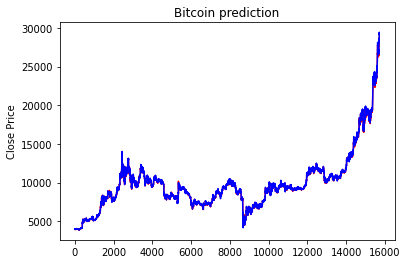

In [51]:
# Visualizing the results
plt.plot(real_values, color = 'red', label = 'Real')
plt.plot(predictions, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

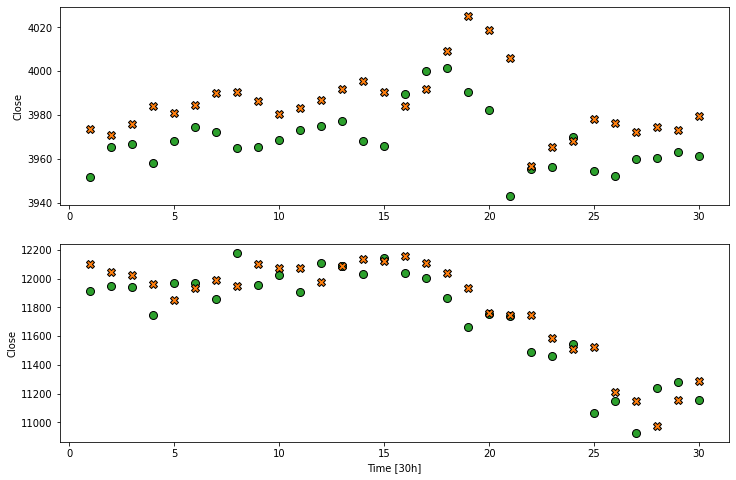

In [52]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 2500)

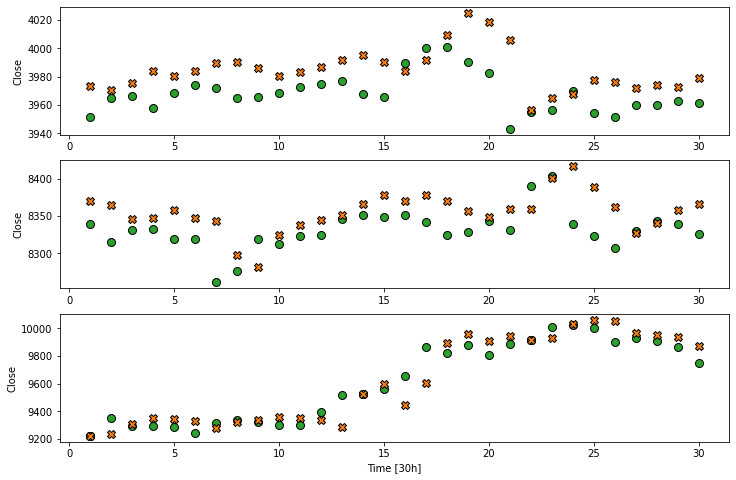

In [53]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 5000)

In [54]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/MachineLearningProject/nn_for_bitcoin_price_1h_single_step.h5")


# Convolutional Model

In [102]:
np.random.seed(42)
window_len = 48
test_size = 0.2
epochs = 20
num_features = len(hist_1h.columns)
batch_size = 256
loss = 'mape'
dropout = 0.2
output_size = 1
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [103]:
def build_conv_model(output_size, filters=512, loss='mape', optimizer='adam'):
    CONV_WIDTH = 3
    model = Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
    model.add(tf.keras.layers.Conv1D(filters = filters, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(tf.keras.layers.Dense(output_size, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([output_size]))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mape'])
    return model

In [104]:
model = build_conv_model(output_size=output_size, loss=loss, optimizer=optimizer)

In [105]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/20
247/247 [==============================] - 1s 4ms/step - loss: 83.1408 - mape: 83.1408
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 46.1912 - mape: 46.1912
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 20.4572 - mape: 20.4572
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 41.9189 - mape: 41.9189
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0435 - mape: 8.0435
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 29.8362 - mape: 29.8362
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 17.4864 - mape: 17.4864
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 33.8023 - mape: 33.8023
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 54.2396 - mape: 54.2396
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4882 - mape: 7.4882
Epoch 11/20
247/247 [==

In [106]:
results = model.evaluate(X_test, y_test)
results

491/491 [==============================] - 1s 1ms/step - loss: 0.5842 - mape: 0.5842


[0.5841878056526184, 0.5841878056526184]

In [107]:
preds = model.predict(X_test)

In [108]:
r2_score(y_test, preds)

0.9992269388055209

In [109]:
predictions = scaler2.inverse_transform(preds)
y_test = y_test.reshape(-1,1)
real_values = scaler2.inverse_transform(y_test)

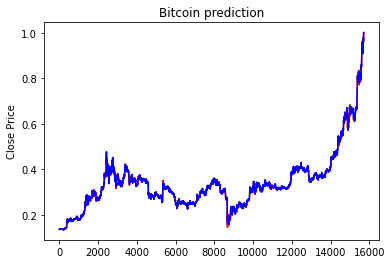

In [110]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

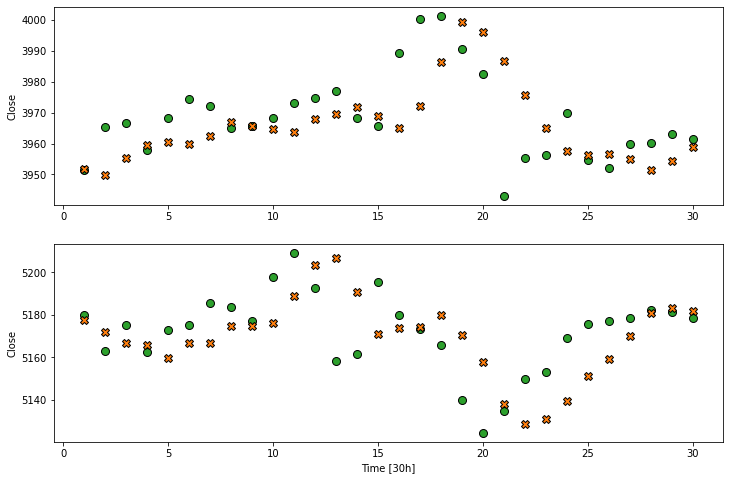

In [111]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 1000)

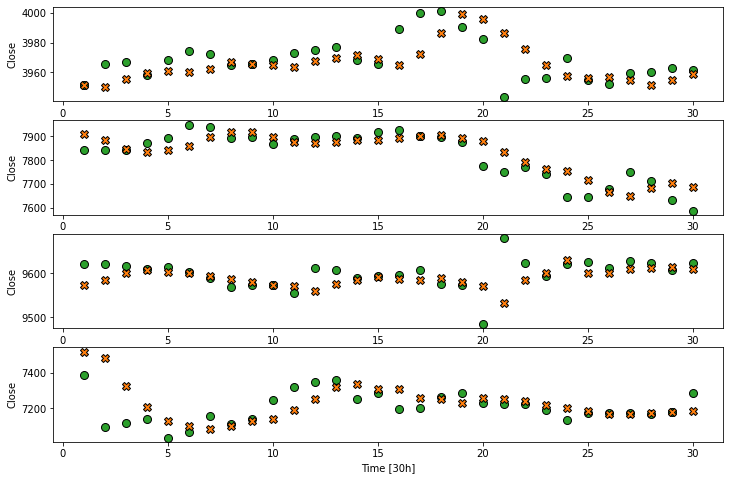

In [112]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=4, print_step = 2000)

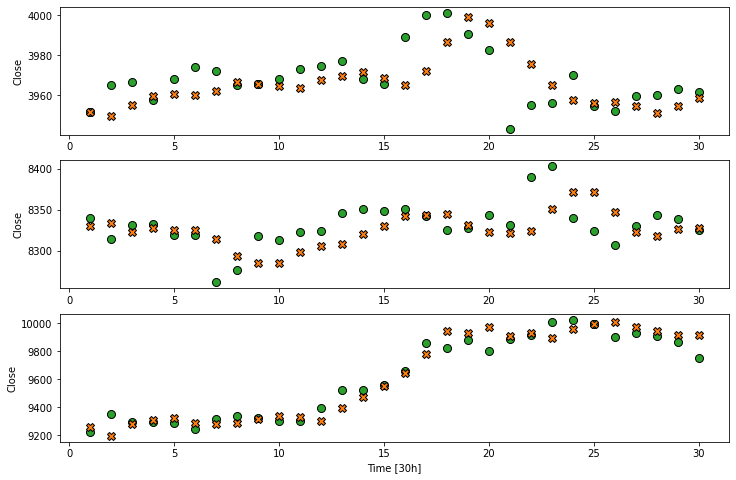

In [113]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 5000)

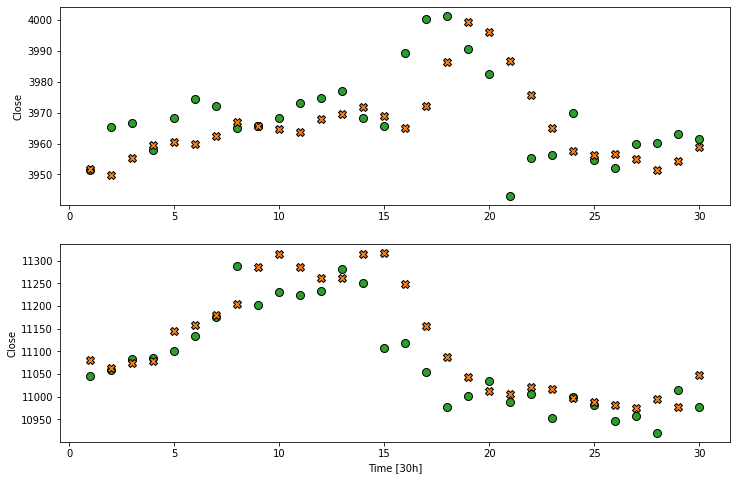

In [114]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 12000)

In [115]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/MachineLearningProject/cnn_for_bitcoin_price_1h_single_step.h5")

# Detrending

In [ ]:
with open('/content/drive/MyDrive/MachineLearningProject/Dataset/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv', 'r') as f:
  hist = pd.read_csv(f)
hist.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hist = replace_NaN(hist)
hist.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [ ]:
hist.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [ ]:
hist = hist.set_index(['Timestamp'])

In [ ]:
hist.index = pd.to_datetime(hist.index, unit='s')

In [ ]:
hist.isna().sum()#should be zero

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [ ]:
hist.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [ ]:
hist.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
2020-12-30 23:59:00,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831
2020-12-31 00:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


In [ ]:
hist_1h = hist.resample('1h')
hist_1h = hist_1h.asfreq()
hist_1h =  hist_1h.dropna(axis = 0, how = 'any')
hist_1h.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [ ]:
hist_1h.shape

(78797, 7)

In [ ]:
hist_1h.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 08:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 09:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 10:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 11:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 12:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [ ]:
hist_1h.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 20:00:00,28807.89,28830.00,28768.13,28827.23,5.653226,1.628806e+05,28811.974988
2020-12-30 21:00:00,28789.77,28808.04,28673.31,28783.67,89.293552,2.566554e+06,28742.886742
2020-12-30 22:00:00,28896.96,28925.51,28896.96,28907.59,1.452840,4.200696e+04,28913.679200
2020-12-30 23:00:00,28731.27,28756.10,28714.03,28728.12,5.567706,1.599935e+05,28735.980712
2020-12-31 00:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,1.664497e+05,28909.166061


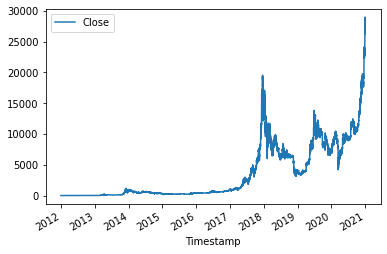

In [ ]:
plot_cols = ['Close']
plot_features = hist_1h[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
hist_1h = hist_1h.diff()
hist_1h.isna().sum()

Open                 1
High                 1
Low                  1
Close                1
Volume_(BTC)         1
Volume_(Currency)    1
Weighted_Price       1
dtype: int64

In [ ]:
hist_array = hist_1h.to_numpy()[1:]
hist_1h = pd.DataFrame(data = hist_array, columns = hist_1h.columns)

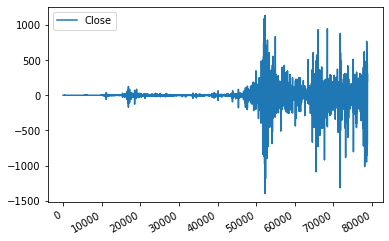

In [ ]:
plot_cols = ['Close']
plot_features = hist_1h[plot_cols]
_ = plot_features.plot(subplots=True)

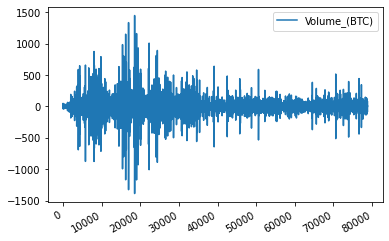

In [ ]:
plot_cols = ['Volume_(BTC)']
plot_features = hist_1h[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
target_col = 'Close'
target_index = 3

In [ ]:
target = train[target_col].to_numpy()
target = target.reshape(-1,1)
scaler = MinMaxScaler()

scaler2 = MinMaxScaler()
scaler2.fit(target)

hist_array = scaler.fit_transform(hist_1h)

In [ ]:
hist_array[1000]

array([0.56189033, 0.54532769, 0.53708551, 0.55219904, 0.48976122,
       0.49946843, 0.54281878])

In [ ]:
np.random.seed(42)
window_len = 48
test_size = 0.2
lstm_neurons = 200
epochs = 10
num_features = len(hist_1h.columns)
activ_func = 'linear'
batch_size = 64
loss = 'mape'
dropout = 0.2
output_size = 1
optimizer = keras.optimizers.Adam(learning_rate=0.0003)

In [ ]:
X_train, y_train, X_test, y_test = prepare_data(hist_array, window_len=window_len, test_size=test_size)

In [ ]:
def build_lstm_model(window_len, num_features, output_size, neurons=50, activ_func='linear', dropout=0.2, loss='mape', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units = neurons, input_shape =(window_len, num_features)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mape', 'mae'])
    
    return model

In [ ]:
model = build_lstm_model(window_len, num_features, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               166400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/10
 30/985 [..............................] - ETA: 2:24 - loss: 158.1506 - mape: 158.1506 - mae: 0.2499

KeyboardInterrupt: ignored

In [ ]:
results = model.evaluate(X_test, y_test)

379/379 [==============================] - 13s 33ms/step - loss: 103.4403 - mape: 103.4403 - mae: 0.7151


In [ ]:
preds = model.predict(X_test)

In [ ]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

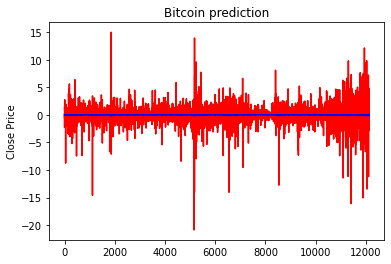

In [ ]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

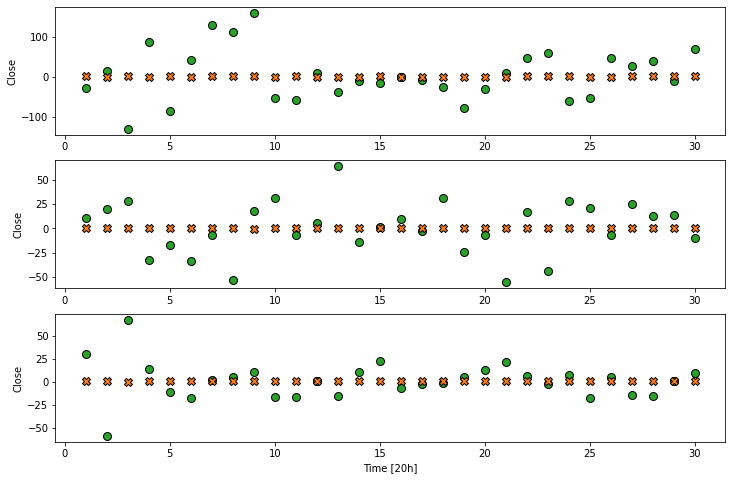

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 5000)